## Ground roll removal

#### Author: Francesco Brandolin



In [3]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import pylops
import time
from itertools import cycle

import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader

from signal_sep_pinns.Arch_Adaptive import Network
from signal_sep_pinns.ArchPE import NetworkPE
from signal_sep_pinns.train_functions import train_grr_pinnslope
from signal_sep_pinns.utils import *

# set device to use CPU/GPU:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
print('What device are we using:', device)
dtype = torch.cuda.FloatTensor

# set seed:
set_seed(42)
g = torch.Generator()
g.manual_seed(0)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
What device are we using: cuda:0


In [4]:
# Load experiment parameters:

synth_data = {'dir':'../data/ground_roll/synth_data.npy',
            'ox': 266, 'dx':18.78, 'nx':266+267, 
            'ot':0, 'dt':0.004, 'nt':320+306,
            'nsub':2,
            'epochs':1000,
            'lamda':1000,
            'slope_constraint':0.7,
            'first_derivative':False,
            'second_derivative':False,
            'lamda2':None # needed only if derivative loss term is applied
            }

sand_dunes_data = {'dir':'../data/ground_roll/sand_dunes.npy',
            'ox': 48, 'dx':50, 'nx':78, 
            'ot':0, 'dt':0.004, 'nt':512,
            'nsub':1,
            'epochs':2000,
            'lamda':10,
            'slope_constraint':0.3,
            'first_derivative':False,
            'second_derivative':True,
            'lamda2':1000 # needed only if derivative loss term is applied
            }

kaust_data = {'dir':'../data/ground_roll/GRKAUST.npy',
            'ox': 76, 'dx':2, 'nx':76+41, 
            'ot':0, 'dt':0.001, 'nt':500,
            'nsub':1,
            'epochs':2000,
            'lamda':10,
            'slope_constraint':0.3,
            'first_derivative':False,
            'second_derivative':True,
            'lamda2':1000 # needed only if derivative loss term is applied
            }

#### Select the experiment to run:

In [5]:
# Decide which data to remove the ground roll:
par = sand_dunes_data

#### Prepare and display the data:

Data shape: (30, 512)
Restriction Op. shape: (15360, 15360)
Subsampled data shape: (512, 30)
data_mask shape: (512, 30)


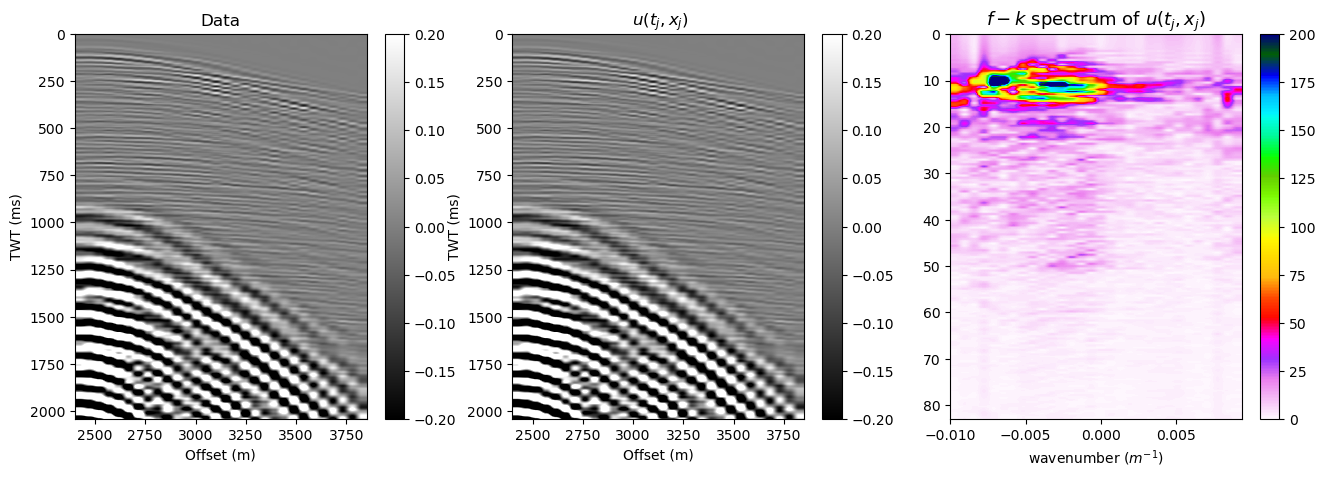

In [ ]:
# Creates a directory to save the results:
value='ground_roll_synth'
saveres = '../data/results/{}'.format(value)
saving_results_dir(saveres)

# Load the data:
data = np.load(par['dir']).T
print('Data shape:',data.shape)

# Data dimensions:
ox, dx,  nx = par['ox'], par['dx'], par['nx']
ot, dt, nt = par['ot'], par['dt'], par['nt']
dim_x = int(nx-ox); dim_t = int(nt-ot) 
x = (np.arange(dim_x)+ ox)* dx
x = np.reshape(x, (dim_x, 1) )
t = ((np.arange(dim_t)+ ot) * dt)*1e3
t = np.reshape(t, (dim_t, 1) )

# Subsample factor:
nsub = par['nsub'] # (if set to 1 no subsampling)


# Create restriction operator:
traces_index = np.arange( dim_x )
traces_index_sub = traces_index[::nsub]  
Rop = pylops.Restriction([dim_x, dim_t], 
                         iava=traces_index_sub, 
                         axis=0, 
                         dtype="float64" 
                         )
print('Restriction Op. shape:',Rop.shape)

# Apply restriction Operator to the data:
data_obs, datamask = ROp(Rop, data, traces_index_sub, dim_t)

# Display CMP and Trace selected:
fig, axs = plt.subplots(1, 3, figsize=(16, 5), gridspec_kw={'width_ratios': [1, 1, 1]})
vmin=-.2; vmax=.2
CMP = axs[0].imshow(data.T, cmap='gray', vmin=vmin, vmax=vmax, extent=(x[0, 0], x[-1, -1], t[-1, -1], t[0, 0]))
axs[0].set_xlabel('Offset (m)')
axs[0].set_ylabel('TWT (ms)')
axs[0].set_title('Data')
fig.colorbar(CMP, ax=axs[0])
axs[0].axis('tight')

CMP1 = axs[1].imshow(datamask.data, cmap='gray', vmin=vmin, vmax=vmax, extent=(x[0, 0], x[-1, -1], t[-1, -1], t[0, 0]))
axs[1].set_xlabel('Offset (m)')
axs[1].set_ylabel('TWT (ms)')
axs[1].set_title(r' $u(t_{j}, x_{j})$')
fig.colorbar(CMP1, ax=axs[1])
axs[1].axis('tight')

f, kx = np.fft.fftfreq(dim_t, dt), np.fft.fftfreq(dim_x, dx)
FFTsub = np.fft.fft2(datamask[:,:])

limit_plot=FFTsub.shape[0]//3
FFTsubdata=axs[2].imshow(np.fft.fftshift(np.abs(FFTsub[:limit_plot]), axes=1), cmap='gist_ncar_r', vmin=0, vmax=200, extent=(np.fft.fftshift(kx)[0], np.fft.fftshift(kx)[-1], f[limit_plot], f[0]) )
axs[2].set_xlabel('wavenumber ($m^{-1}$)',)
axs[2].set_title('$f-k$ spectrum of'+r' $u(t_{j}, x_{j})$', fontsize=13)
fig.colorbar(FFTsubdata, ax=axs[2])
axs[2].axis('tight')
# plt.savefig(saveres + "/intro.png", format='png', bbox_inches='tight')
plt.show()

### Creating and processing the computational grid

- In this cell the computational grid is created. Then the grid points associated with the position of training traces (right fig. above) are extracted, these are the points passed in the data term of the loss.
  
- Also, the training traces are reshaped and stacked one below the other to be easily pass to the data-term term during the network training.
- If the data derivative term is utilized, the above procedures are applied to the derivative training traces as well.

full_grid size (15360, 2)
traces_training_grid size: (15360, 2)
ground_truth_traces size: (15360, 1)
Subsampled data shape: (512, 30)
data_mask shape: (512, 30)
dudt1_traces size: (15360, 1)
Subsampled data shape: (512, 30)
data_mask shape: (512, 30)
dudt2_traces size: (15360, 1)


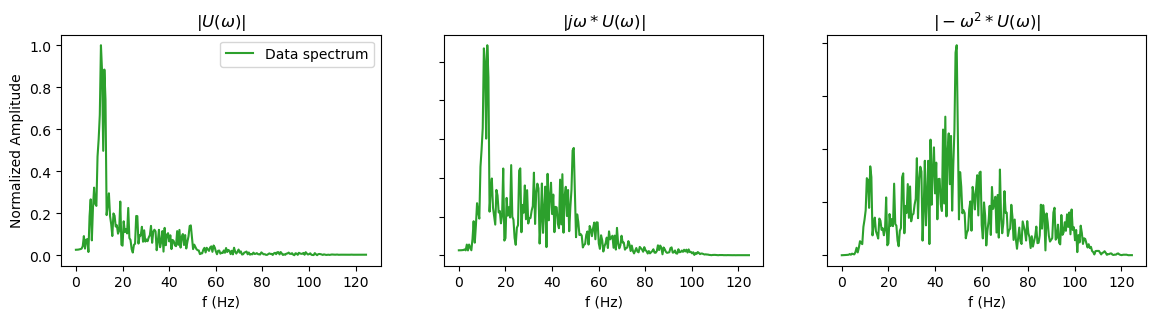

In [8]:
# Creating computational grid:
grx, grt, grX, grT, full_grid = grid(ox, dx, nx, ot, dt, nt, normalization=True)
print('full_grid size', full_grid.shape )

# Creating training traces grid-points from full grid:
traces_training_grid = grid_subsampling(grX, grT, Rop, traces_index_sub.shape[0])
print('traces_training_grid size:', traces_training_grid.shape)

# Reshaping subsampled data to trainig traces:
ground_truth_traces = training_traces(data_obs)
print('ground_truth_traces size:', ground_truth_traces.shape)


if par['first_derivative'] or par['second_derivative'] == True:
    
    # 1st derivative:
    D1 = pylops.FirstDerivative((dim_x,dim_t ))
    data_der = D1@data.ravel()
    datadt1 = data_der.reshape((dim_x,dim_t )).T
    # Apply restriction operator to derivative traces:
    datadt1, _ = ROp(Rop, datadt1.T, traces_index_sub, dim_t)
    dudt1_traces = training_traces(datadt1)
    print('dudt1_traces size:', dudt1_traces.shape)

    # 2nd derivative:
    D2 = pylops.SecondDerivative((dim_x,dim_t ))
    data_der2 = D2@data.ravel()
    datadt2 = data_der2.reshape((dim_x,dim_t )).T
    # Reshaping subsampled derivative data to training traces:
    datadt2, _ = ROp(Rop, datadt2.T, traces_index_sub, dim_t)
    dudt2_traces = training_traces(datadt2)
    print('dudt2_traces size:', dudt2_traces.shape)


    # Visualizing frequency spectrum of the data:
    f = np.fft.fftfreq(nt, dt)
    F = np.fft.fft(np.average(data.T ,axis=1))

    fig, axs = plt.subplots(1, 3, figsize=(14, 3), gridspec_kw={'width_ratios': [1, 1, 1]})
    limit1 = int(dim_t/2)
    limit2 = int(f.shape[0]/2)
    axs[0].plot(f[:limit1],(np.abs(F[:limit1]))/np.max(np.abs(F)),color='C2')
    axs[0].set_title(r'$|U(\omega)|$')
    axs[0].set_xlabel('f (Hz)')
    axs[0].set_ylabel('Normalized Amplitude')
    axs[0].legend(['Data spectrum', 'Filter f. response'])
    FFTdatadt1 = np.fft.fft(np.mean(datadt1, axis=1))
    axs[1].plot( f[:limit1], (np.abs(FFTdatadt1[:limit1]))/np.max(np.abs(F)), color='C2' )
    axs[1].set_title(r'$|j\omega*U(\omega)|$')
    axs[1].set_xlabel('f (Hz)')
    axs[1].set_yticklabels([])
    FFTdatadt2 = np.fft.fft(np.mean(datadt2, axis=1))
    axs[2].plot( f[:limit1], (np.abs(FFTdatadt2[:limit1]))/np.max(np.abs(F)), color='C2' )
    axs[2].set_title(r'$|-\omega^{2}*U(\omega)|$')
    axs[2].set_xlabel('f (Hz)')
    axs[2].set_yticklabels([])

    plt.show()


### Hyperparameteres settings, Network initialization and Dataloader

- Sets the hyperparameters for training.

- Creates two TensorDatasets one with the full grid and one with the training traces grid points and the training traces (and if available the derivative training traces as well). 

In [ ]:
# Choose the learning rate:
lr = 1e-3
# Choose number of epochs:
epochs = par['epochs']

# Grid batches:
batch_grid_slope = 1000
n_grid_slope_batches = int((full_grid.shape[0])/batch_grid_slope)
print(' - Number of Grid/Slope batches:', n_grid_slope_batches)

# Training traces batches:
n_train_traces_batches = 2
batch_traces_size = int((ground_truth_traces.shape[0])/n_train_traces_batches)
print(' - Traces batch size:',batch_traces_size)

# Data term Loss function:
Loss1 = nn.L1Loss(reduction='mean')

# Define the weight for the data term:
lamdas = [par['lamda'], par['lamda2'] ]

# Scaling for the derivative:
derivative_scaling = torch.tensor(dt*1e3/t[-1]).to(device)

# Wavefield network:
lay = 'linear' 
act = 'Tanh'  
PosEnc=[8,32,2]
model = NetworkPE((PosEnc[0]*2+PosEnc[1]*2), 
                  1, 
                  [512,512,512,512], 
                  act=act, 
                  lay=lay, 
                  PosEnc=PosEnc, 
                  device=device
                  ).to(device)

# Choose the optimizer:
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

# Slope network:
modelSlope = Network(2, 
                     1, 
                     [2,2], 
                     act=act, 
                     lay=lay
                     ).to(device)

# Optimizer:
optimizer_slope = torch.optim.Adam(modelSlope.parameters(), lr=lr)

# Preparing DataLoaders for grid-points (t_i, x_i):
grid_slope = torch.from_numpy(full_grid).type(dtype).to(device)
print(' - Torch Tens grid-slope points size:',grid_slope.shape)
# grid_slope = TensorDataset(grid_slope)

fullgrid_loader = DataLoader( TensorDataset(grid_slope), 
                                batch_size=batch_grid_slope, 
                                shuffle=True, 
                                drop_last=True, 
                                generator=g
                                )

# Preparing DataLoaders for grid-points (t_j, x_j) and available data u(t_j, x_j):
if par['first_derivative'] or par['second_derivative'] == True:
    tracesGrid_tracesGT = np.concatenate(( traces_training_grid, ground_truth_traces, dudt2_traces ), axis=1)
else:
    tracesGrid_tracesGT = np.concatenate(( traces_training_grid, ground_truth_traces), axis=1)
    print('Concat of grid and ground truth traces points size:', tracesGrid_tracesGT.shape)

tracesGrid_tracesGT = torch.from_numpy(tracesGrid_tracesGT).type(dtype).to(device)
print(' - Torch Tens grid-GT points size:',tracesGrid_tracesGT.shape)

tracesGrid_tracesGT_loader = DataLoader( TensorDataset( tracesGrid_tracesGT ), 
                                        batch_size=batch_traces_size, 
                                        shuffle=True, 
                                        drop_last=True, 
                                        generator=g
                                        )

 - Number of Grid/Slope batches: 15
 - Traces batch size: 7680
 - Torch Tens grid-slope points size: torch.Size([15360, 2])
 - Torch Tens grid-GT points size: torch.Size([15360, 4])


### PINNslope training loop

In [ ]:
training_loss, loss_data_values, loss_derivatives_values, loss_phy_values = np.zeros(epochs), np.zeros(epochs), np.zeros(epochs), np.zeros(epochs)

start = time.time()

# Run the network:
for epoch in range( epochs ):
    
    if epoch % 100==0:
        print('epoch:', epoch)

    training_loss[epoch], loss_data_values[epoch], loss_derivatives_values[epoch], loss_phy_values[epoch] = \
        train_grr_pinnslope( [model, modelSlope], 
                            [optimizer, optimizer_slope], 
                            Loss1, 
                            lamdas,  
                            fullgrid_loader, 
                            tracesGrid_tracesGT_loader, 
                            derivative_scaling, 
                            c=par['slope_constraint'],
                            first_derivative=par['first_derivative'],
                            second_derivative=par['second_derivative']
                            ) 

end = time.time()
print('Total Runtime is: %f [minutes] ' %((end-start)/60))

In [20]:
## Model evaluation and plotting:
model.eval()
u_out = model( torch.from_numpy(full_grid).type(dtype).requires_grad_(True) )
u_npy = ( np.reshape(u_out.detach().cpu().numpy(), (dim_x, dim_t)) ).T


modelSlope.eval()
# Constrain output:
sigmoid = torch.nn.Sigmoid()
c = torch.tensor(par['slope_constraint']) # reflections prediction

sigma_out = sigmoid( modelSlope( torch.from_numpy(full_grid).type(dtype).to(device).requires_grad_(True) ) ) * c
sigma_npy = ( np.reshape(sigma_out.detach().cpu().numpy(), (dim_x, dim_t)) ).T

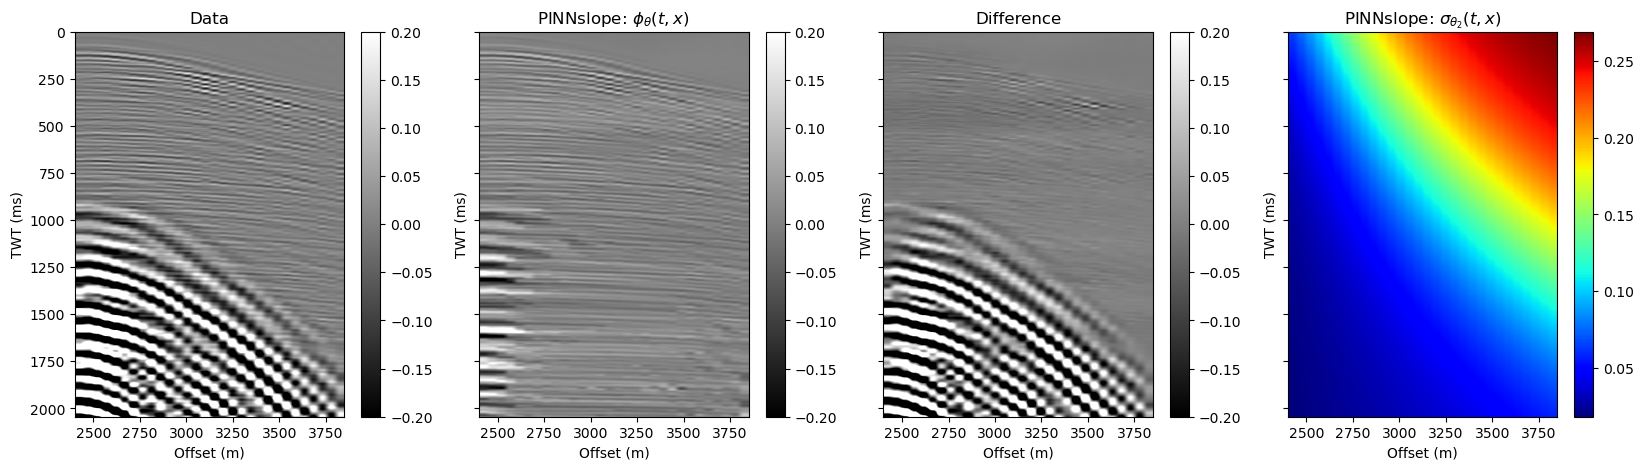

In [56]:
# Results:
fig, axs = plt.subplots(1, 4, sharey=True, figsize=(20, 5), gridspec_kw={'width_ratios': [1, 1, 1, 1]})

vmin=-0.2; vmax=0.2

CMP=axs[0].imshow(data.T, cmap='gray', vmin=vmin, vmax=vmax, extent=(x[0,0], x[-1,-1], t[-1,-1], t[0,0]))
axs[0].set_xlabel('Offset (m)')
axs[0].set_ylabel('TWT (ms)')
axs[0].set_title('Data')
fig.colorbar(CMP, ax=axs[0])
axs[0].axis('tight')

OUT=axs[1].imshow(u_npy, cmap='gray',  vmin=vmin, vmax=vmax, extent=(x[0,0], x[-1,-1], t[-1,-1], t[0,0]))
axs[1].set_xlabel('Offset (m)')
axs[1].set_ylabel('TWT (ms)')
axs[1].set_title('PINNslope: ' + r'$\phi_{\theta}(t,x)$ ' )
fig.colorbar(OUT, ax=axs[1])
axs[1].axis('tight')

DIFF=axs[2].imshow((data.T-u_npy), cmap='gray', vmin=vmin, vmax=vmax, extent=(x[0,0], x[-1,-1], t[-1,-1], t[0,0]))
axs[2].set_xlabel('Offset (m)')
axs[2].set_ylabel('TWT (ms)')
axs[2].set_title('Difference' )
fig.colorbar(DIFF, ax=axs[2])
axs[2].axis('tight')

SLOPE=axs[3].imshow(sigma_npy, cmap='jet', extent=(x[0,0], x[-1,-1], t[-1,-1], t[0,0]))
axs[3].set_xlabel('Offset (m)')
axs[3].set_ylabel('TWT (ms)')
axs[3].set_title('PINNslope: ' + r'$ \sigma_{\theta_{2}}(t,x)$' )
fig.colorbar(SLOPE, ax=axs[3])
axs[3].axis('tight')

# plt.savefig(saveres + "/result.png", format='png', bbox_inches='tight')
plt.show()

In [ ]:
if par['first_derivative'] or par['second_derivative'] == True:
    plt_loss_der(epochs, loss_phy_values, loss_data_values, training_loss, loss_derivatives_values )
else:
    plot_loss(epochs, loss_phy_values, loss_data_values, training_loss )

# plt.savefig(saveres + "/loss.png", format='png', bbox_inches='tight')
plt.show()

In [ ]:
# Store the hyperparameters used in the current experiment in .txt file
store_param = {'runtime':(end-start)/60, 
               'epochs':epochs, 
               'lr':lr, 
               'lambda':par['lamda'],
               'lambda2':par['lamda2'],
               'slope_constraint': par['slope_constraint'],
               'DataNetwork':model,
               'SlopeNetwork':modelSlope}
with open(saveres + '/param_summary.txt', 'w') as f:
    f.write("%s = %s\n" %("store_param", store_param))


## Uncomment to save output files:

# torch.save(model.state_dict(), saveres + '/u.pt')
# torch.save(modelSlope.state_dict(), saveres + '/slope.pt')
# np.save(saveres + '/u.npy', u_npy)
# np.save(saveres + '/slope.npy', sigma_npy)
# np.save(saveres + '/lossphy.npy', loss_phy_values)
# np.save(saveres + '/lossdata.npy', loss_data_values)
# np.save(saveres + '/losstot.npy', loss_values)

# if first_derivative or second_derivative == True:
#     np.save(saveres + '/lossder.npy', loss_derivatives_data_values)